In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os, warnings
import numpy as np
import pandas as pd
from keras.preprocessing import image
import glob

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

tf.distribute.MirroredStrategy(
    devices=None, cross_device_ops=None
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [2]:
dir_name='dataset/images/*'

pets_files = glob.glob(dir_name) 
pets_df = pd.DataFrame(pets_files)

In [3]:
pets_df.columns =['full_path']
pets_df['file_name'] = pets_df['full_path'].str.split('\\').str[1]

In [4]:
# labels in this dataset are in the file name
pets_df['label'] = pets_df['file_name'].str[0].str.isupper().map({True:'1', False:'0'})

In [62]:
datagen = image.ImageDataGenerator(rescale=1/255., validation_split=0.2)

#ultima alteracao: removi o .sample do pets_df e suffle=False.

train_generator = datagen.flow_from_dataframe(dataframe=pets_df, 
                                              directory= 'dataset/images',
                                              x_col='file_name',
                                              y_col='label',
                                              target_size=(256,256),
                                              class_mode='binary',
                                              batches=200,
                                              shuffle=False,
                                              subset='training'
                                             )

validation_generator = datagen.flow_from_dataframe(dataframe=pets_df, 
                                                   directory= 'dataset/images',
                                                   x_col='file_name',
                                                   y_col='label',
                                                   target_size=(256,256),
                                                   class_mode='binary',
                                                   subset='validation', 
                                                   batches=200,
                                                   shuffle=False,
                                                   seed=7
                                             )

C:\Users\Ferrazzo\anaconda3\envs\tensorflorw\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


Found 5912 validated image filenames belonging to 2 classes.
Found 1478 validated image filenames belonging to 2 classes.


C:\Users\Ferrazzo\anaconda3\envs\tensorflorw\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [6]:
train_generator.__dict__['classes'].count(1)/len(train_generator.__dict__['classes'])

0.4887937547217326

In [7]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=5, 
                              min_lr=0.001)

Epoch 1/50
185/185 [==============================] - 41s 217ms/step - loss: 0.6245 - accuracy: 0.6703 - val_loss: 0.6127 - val_accuracy: 0.6766
Epoch 2/50
185/185 [==============================] - 40s 218ms/step - loss: 0.6091 - accuracy: 0.6729 - val_loss: 0.6102 - val_accuracy: 0.6773
Epoch 3/50
185/185 [==============================] - 47s 252ms/step - loss: 0.6073 - accuracy: 0.6749 - val_loss: 0.6357 - val_accuracy: 0.6766
Epoch 4/50
185/185 [==============================] - 48s 261ms/step - loss: 0.5981 - accuracy: 0.6747 - val_loss: 0.5893 - val_accuracy: 0.6854
Epoch 5/50
185/185 [==============================] - 51s 274ms/step - loss: 0.5899 - accuracy: 0.6842 - val_loss: 0.5811 - val_accuracy: 0.6874
Epoch 6/50
185/185 [==============================] - 56s 303ms/step - loss: 0.5830 - accuracy: 0.6894 - val_loss: 0.5664 - val_accuracy: 0.6874
Epoch 7/50
185/185 [==============================] - 63s 339ms/step - loss: 0.5629 - accuracy: 0.7033 - val_loss: 0.5504 - val_ac

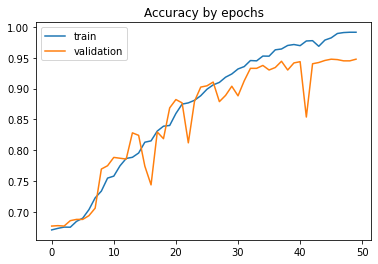

In [8]:
model =  keras.Sequential([
    keras.layers.Conv2D(32,5,5, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)

model.compile(optimizer=optimizer, loss='BinaryCrossentropy', metrics=['accuracy'])

model_performance = model.fit(train_generator, 
                              validation_data= validation_generator, 
                              callbacks=[reduce_lr], 
                              epochs=50)

plt.plot(model_performance.history['accuracy'])
plt.plot(model_performance.history['val_accuracy'])
plt.title('Accuracy by epochs')
plt.legend(['train', 'validation'])

In [9]:
folder = 'models/01_02_22'
model.save(folder)
pd.DataFrame.from_dict(model_performance.history).to_csv(folder + '/history.csv',index=False)

INFO:tensorflow:Assets written to: models/94_val_acc_31_01_22\assets


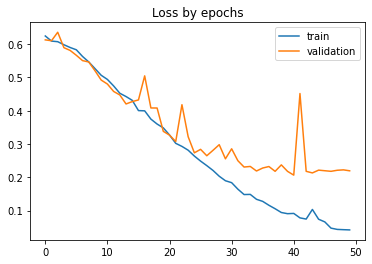

In [14]:
plt.plot(model_performance.history['loss'])
plt.plot(model_performance.history['val_loss'])
plt.title('Loss by epochs')
plt.legend(['train', 'validation'])

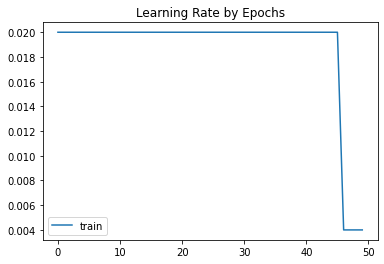

In [15]:
plt.plot(model_performance.history['lr'])
plt.title('Learning Rate by Epochs')
plt.legend(['train'])

In [64]:
train_pred = model.predict(validation_generator)
confus_matrix = tf.math.confusion_matrix(labels=validation_generator.__dict__['classes'], predictions=train_pred.ravel()>0.5)

In [66]:
confus_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[783,  17],
       [ 60, 618]])>